## Convert the TensorFlow 3D UNet model with OpenVINO Model Optimizer 

In [15]:
!echo $CONDA_PREFIX

/home/ubuntu/miniconda3/envs/jupyter_launch


In [16]:
!pwd

/home/ubuntu/brats_2018_on_intel/notebooks


In [17]:
#!pip install openvino-dev[tensorflow2] # Recommend installing from the terminal, but not sure if that works with kernel environments

In [18]:
#!mo -h

In [19]:
import time
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
from IPython.display import Markdown
from openvino.runtime import Core

import tensorflow as tf
from tensorflow import keras as K

import nibabel as nib
import numpy as np
import os
import datetime

import sys
sys.path.insert(0, "/home/ubuntu/brats_2018_on_intel/src/") # add path to find user-defined python models
sys.path.insert(0, "/home/ubuntu/miniconda3/envs/optimize_model/bin/") # add path for kernel env due to launching jupyter from different env
#import warnings
#warnings.filterwarnings("ignore")

## Define the settings

In [20]:
DATA_PATH = "/home/ubuntu/brats_2018_on_intel/data/processed/Task01_BrainTumour/"
DATA_DIR = "/home/ubuntu/brats_2018_on_intel/data/processed/"
DATASET = "Task01_BrainTumour/"

TRAIN_TEST_SPLIT = 0.80
VALIDATE_TEST_SPLIT = 0.50

BATCH_SIZE_TRAIN = 8
BATCH_SIZE_VALIDATE = 4
BATCH_SIZE_TEST = 1

TILE_HEIGHT = 144
TILE_WIDTH = 144
TILE_DEPTH = 144
NUMBER_INPUT_CHANNELS = 1

CROP_DIM = (TILE_HEIGHT,TILE_WIDTH,TILE_DEPTH,NUMBER_INPUT_CHANNELS)

NUMBER_OUTPUT_CLASSES = 1


MODEL_DIR = "/home/ubuntu/brats_2018_on_intel/models"
SAVED_MODEL_NAME = "3d_unet_decathlon"
SELECTED_MODEL_EPOCH = 27

FILTERS = 16
NUM_EPOCHS = 40

RANDOM_SEED = 64

OUTPUT_DIR = Path("/home/ubuntu/brats_2018_on_intel/models/openvino")
IR_MODEL_PRECISION = "FP32"

In [21]:
selected_model_name = SAVED_MODEL_NAME + "_epoch_" + str(SELECTED_MODEL_EPOCH)

In [22]:
# The paths of the source and converted models
saved_model_path = Path(Path(MODEL_DIR) / selected_model_name)
fp32_h5_path = Path(saved_model_path / selected_model_name).with_suffix(".h5")

# Path of optimized TF model using OpenVINO Model Optimizer with FP32 precision
fp32_ir_name = Path(SAVED_MODEL_NAME + "_" + "tf" + "_" + "ov" + "_" + "fp32" + "_ir")
fp32_ir_path = Path(OUTPUT_DIR / fp32_ir_name)


In [23]:
# Construct the command for Model Optimizer
mo_command = f"""mo
                 --saved_model_dir "{saved_model_path}"
                 --input_shape "[1,{TILE_HEIGHT},{TILE_WIDTH},{TILE_DEPTH},{NUMBER_INPUT_CHANNELS}]"
                 --data_type "{IR_MODEL_PRECISION}"
                 --output_dir "{OUTPUT_DIR}"
                 --model_name "{fp32_ir_name}"
                 """
mo_command = " ".join(mo_command.split())
print("Model Optimizer command to convert TensorFlow to OpenVINO:")
print(mo_command)

Model Optimizer command to convert TensorFlow to OpenVINO:
mo --saved_model_dir "/home/ubuntu/brats_2018_on_intel/models/3d_unet_decathlon_epoch_27" --input_shape "[1,144,144,144,1]" --data_type "FP32" --output_dir "/home/ubuntu/brats_2018_on_intel/models/openvino" --model_name "3d_unet_decathlon_tf_ov_fp32_ir"


In [24]:
# Run the Model Optimizer (overwrites the older model)
print("Exporting TensorFlow model to IR... This may take a few minutes.")
mo_result = %sx $mo_command
print("\n".join(mo_result))

Exporting TensorFlow model to IR... This may take a few minutes.
Model Optimizer arguments:
Common parameters:
	- Path to the Input Model: 	None
	- Path for generated IR: 	/home/ubuntu/brats_2018_on_intel/models/openvino
	- IR output name: 	3d_unet_decathlon_tf_ov_fp32_ir
	- Log level: 	ERROR
	- Batch: 	Not specified, inherited from the model
	- Input layers: 	Not specified, inherited from the model
	- Output layers: 	Not specified, inherited from the model
	- Input shapes: 	[1,144,144,144,1]
	- Source layout: 	Not specified
	- Target layout: 	Not specified
	- Layout: 	Not specified
	- Mean values: 	Not specified
	- Scale values: 	Not specified
	- Scale factor: 	Not specified
	- Precision of IR: 	FP32
	- Enable fusing: 	True
	- User transformations: 	Not specified
	- Reverse input channels: 	False
	- Enable IR generation for fixed input shape: 	False
	- Use the transformations config file: 	None
Advanced parameters:
	- Force the usage of legacy Frontend of Model Optimizer for model con

In [25]:
# # Run Model Optimizer if the IR model file does not exist
# if not ir_path.exists():
#     print("Exporting TensorFlow model to IR... This may take a few minutes.")
#     ! $mo_command
# else:
#     print(f"IR model {ir_path} already exists.")

## Define a data loader

We'll use `tf.data` to define a way to load the BraTS dataset at runtime whenever a new batch of 3D images and masks are requested.

In [26]:
from data.dataloader import DatasetGenerator

In [27]:
brats_datafiles = DatasetGenerator(data_dir = DATA_DIR,
                                   dataset = DATASET,
                                   data_path = DATA_PATH, 
                                   train_test_split = TRAIN_TEST_SPLIT,
                                   validate_test_split = VALIDATE_TEST_SPLIT,
                                   batch_size_train = BATCH_SIZE_TRAIN,
                                   batch_size_validate = BATCH_SIZE_VALIDATE,
                                   batch_size_test = BATCH_SIZE_TEST,
                                   tile_height = TILE_HEIGHT, 
                                   tile_width = TILE_WIDTH, 
                                   tile_depth = TILE_DEPTH, 
                                   number_input_channels = NUMBER_INPUT_CHANNELS,
                                   crop_dim = (TILE_HEIGHT, TILE_WIDTH,
                                               TILE_DEPTH, NUMBER_INPUT_CHANNELS),
                                   number_output_classes=NUMBER_OUTPUT_CLASSES,
                                   random_seed=RANDOM_SEED)
brats_datafiles.print_info()

Dataset name:         BRATS
Dataset description:  Gliomas segmentation tumour and oedema in on brain images
Tensor image size:    4D
Dataset release:      2.0 04/05/2018
Dataset reference:    https://www.med.upenn.edu/sbia/brats2017.html
Input channels:       {'0': 'FLAIR', '1': 'T1w', '2': 't1gd', '3': 'T2w'}
Output labels:        {'0': 'background', '1': 'edema', '2': 'non-enhancing tumor', '3': 'enhancing tumour'}
Dataset license:      CC-BY-SA 4.0


## Plot some data samples

Plots the MRI and Tumor Masks from a few data samples.

2022-09-19 21:04:39.345761: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


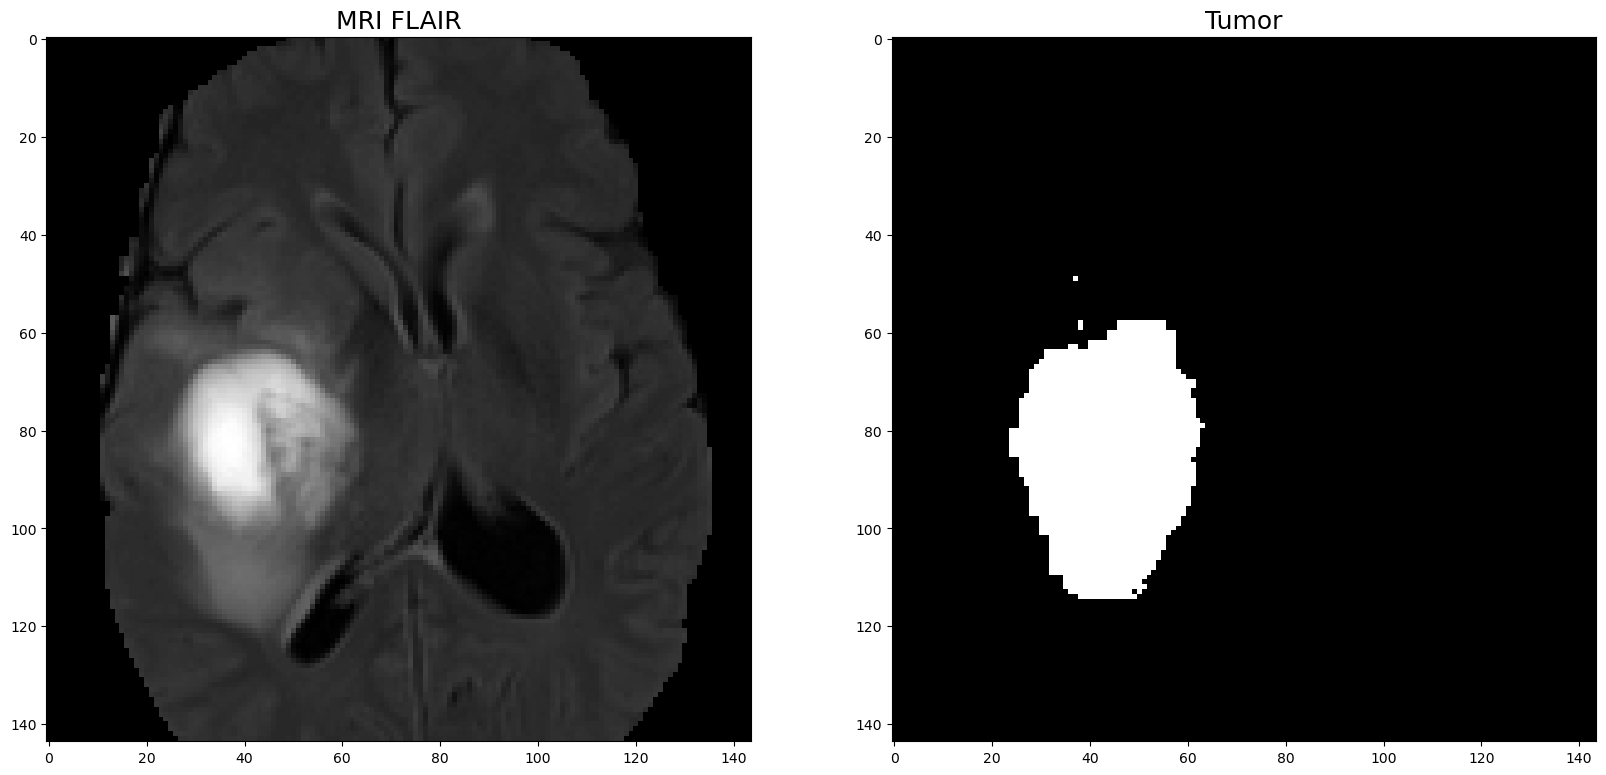

Mean pixel value of image = -1.9810981655155047e-07


In [28]:
%matplotlib inline
brats_datafiles.display_test_images()

In [29]:
path_to_xml_file = f"{fp32_ir_path}.xml"
path_to_bin_file = f"{fp32_ir_path}.bin"

ie = Core()
model = ie.read_model(model=path_to_xml_file, weights=path_to_bin_file)
compiled_model = ie.compile_model(model=model, device_name="CPU")

del model

input_layer = next(iter(compiled_model.inputs))
output_layer = next(iter(compiled_model.outputs))

In [30]:
from models.model import dice_coef, soft_dice_coef, dice_loss
tf_model = tf.keras.models.load_model(fp32_h5_path, 
                                      compile=True, 
                                      custom_objects={"dice_coef":dice_coef, "soft_dice_coef":soft_dice_coef, "dice_loss":dice_loss})

In [31]:
def plot_predictions(img_batch, msk_batch):
    #create a dictionary to store the results of all inferences
    data = {'img': [], 
            'msk': [], 
            'prediction_ov': [], 
            'dice_coef_ov': [],
            'inference_time_ov': [],
            'prediction_tf': [], 
            'dice_coef_tf': [],
            'inference_time_tf': []
           }

    for i in range(img_batch.shape[0]):
        img = img_batch[i:i+1,:,:,:,:]
        msk = msk_batch[i:i+1,:,:,:,:]    
    
        slicenum=np.argmax(np.sum(msk, axis=(1,2)))  # Find the slice with the largest tumor section

        plt.figure(figsize=(20,20))

        plt.subplot(1,4,1)
        plt.title("MRI", fontsize=20)
        plt.imshow(img[0,:,:,slicenum,0], cmap="gray")
        plt.subplot(1,4,2)
        plt.imshow(msk[0,:,:,slicenum,0], cmap="gray")
        plt.title("Ground truth", fontsize=20)

        
        """
        TensorFlow Model Prediction
        """
        start_time = time.time()
        prediction_tf = tf_model.predict(img)
        inference_time_tf = 1000.0*(time.time()-start_time)
        prediction_tf = tf.round(prediction_tf)
        dice_coef_tf = dice_coef(msk,prediction_tf)

        plt.subplot(1,4,3)
        plt.imshow(prediction_tf[0,:,:,slicenum,0], cmap="gray")
        plt.title(f"TensorFlow Prediction\nFP32\nDice = {dice_coef_tf:.4f}\n\nInference time\n{inference_time_tf:.4f} msecs", fontsize=20)

        
        
        """
        OpenVINO Model Prediction - FP32
        Note: OpenVINO assumes the input (and output) are organized as channels first (NCHWD)
        whereas TensorFlow assumes channels last (NHWDC). We'll use the NumPy transpose
        to change the order.
        """
        start_time = time.time()
        request = compiled_model.create_infer_request()
        request.infer(inputs={input_layer.any_name: img})
        prediction_ov = request.get_output_tensor(output_layer.index).data
        inference_time_ov = 1000.0*(time.time()-start_time)
        prediction_ov = tf.round(prediction_ov)
        dice_coef_ov = dice_coef(msk,prediction_ov)

        plt.subplot(1,4,4)
        plt.imshow(prediction_ov[0,:,:,slicenum,0], cmap="gray")
        plt.title(f"OpenVINO Prediction\nFP32\nDice = {dice_coef_ov:.4f}\n\nInference time\n{inference_time_ov:.4f} msecs", fontsize=20)

        
        import pickle

        data['img'].append(img) 
        data['msk'].append(msk)
        data['prediction_ov'].append(prediction_ov) 
        data['dice_coef_ov'].append(dice_coef_ov)
        data['inference_time_ov'].append(inference_time_ov)
        data['prediction_tf'].append(prediction_tf) 
        data['dice_coef_tf'].append(dice_coef_tf)
        data['inference_time_tf'].append(inference_time_tf)

        prediction_results_path = Path(Path(os.getenv('PWD')) / "reports" / "prediction_results.pkl")
        with open(prediction_results_path, 'wb') as outfile:
            pickle.dump(data, outfile, pickle.HIGHEST_PROTOCOL)

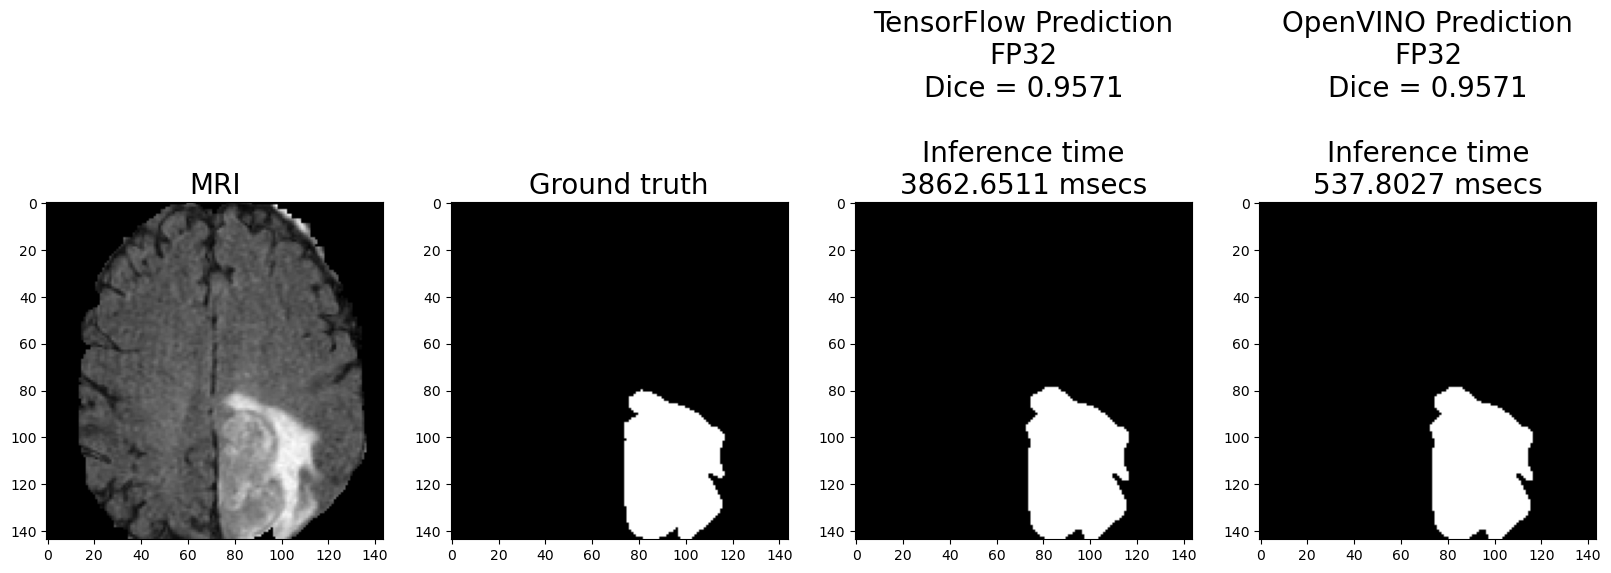

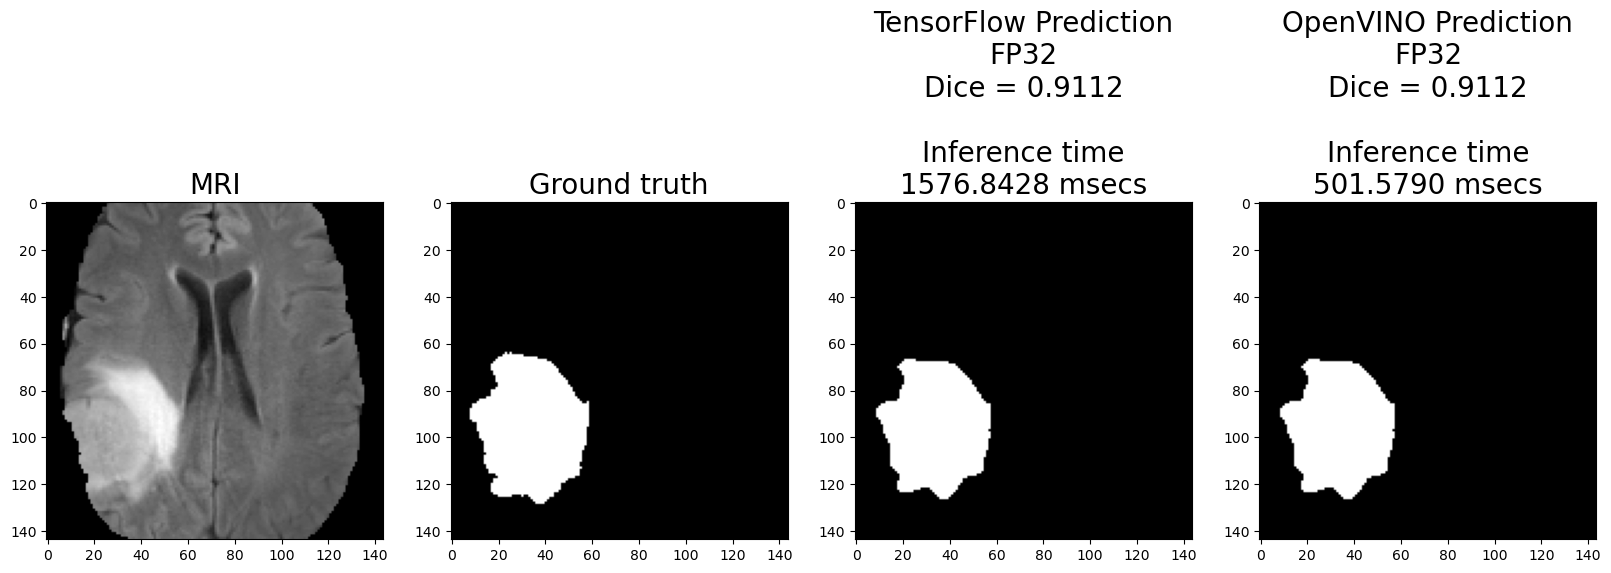

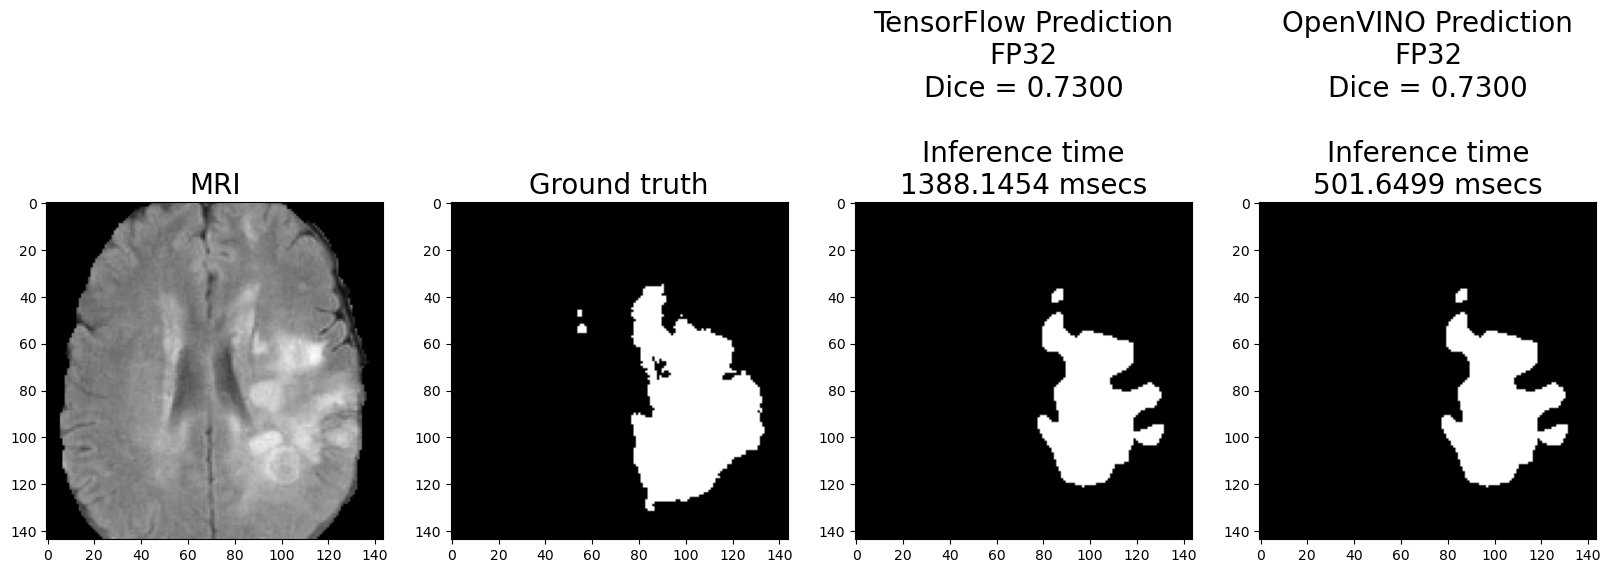

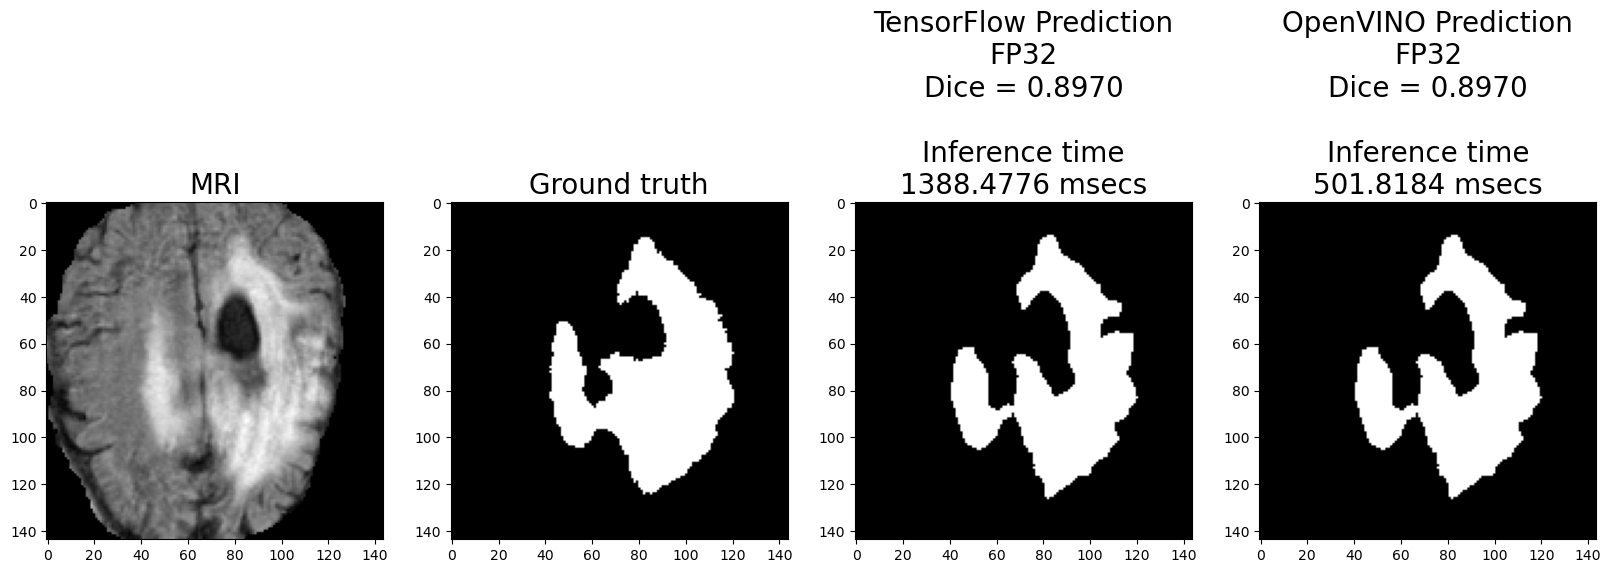

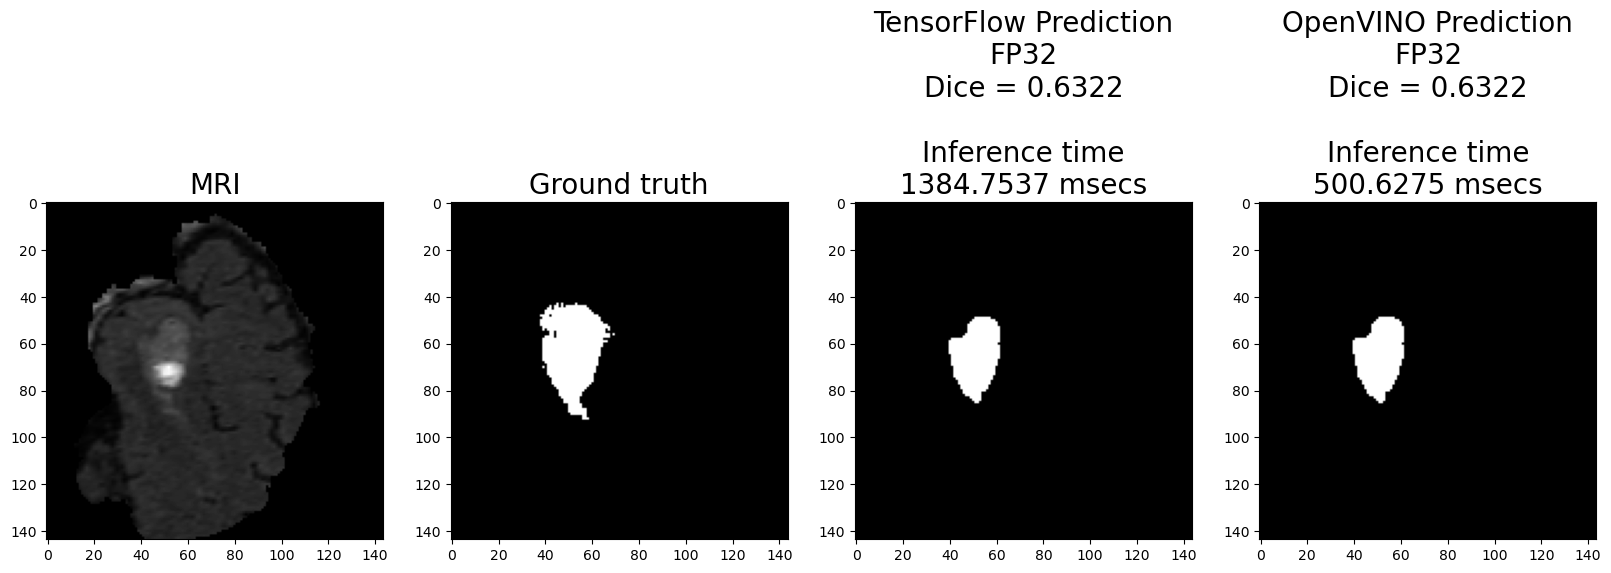

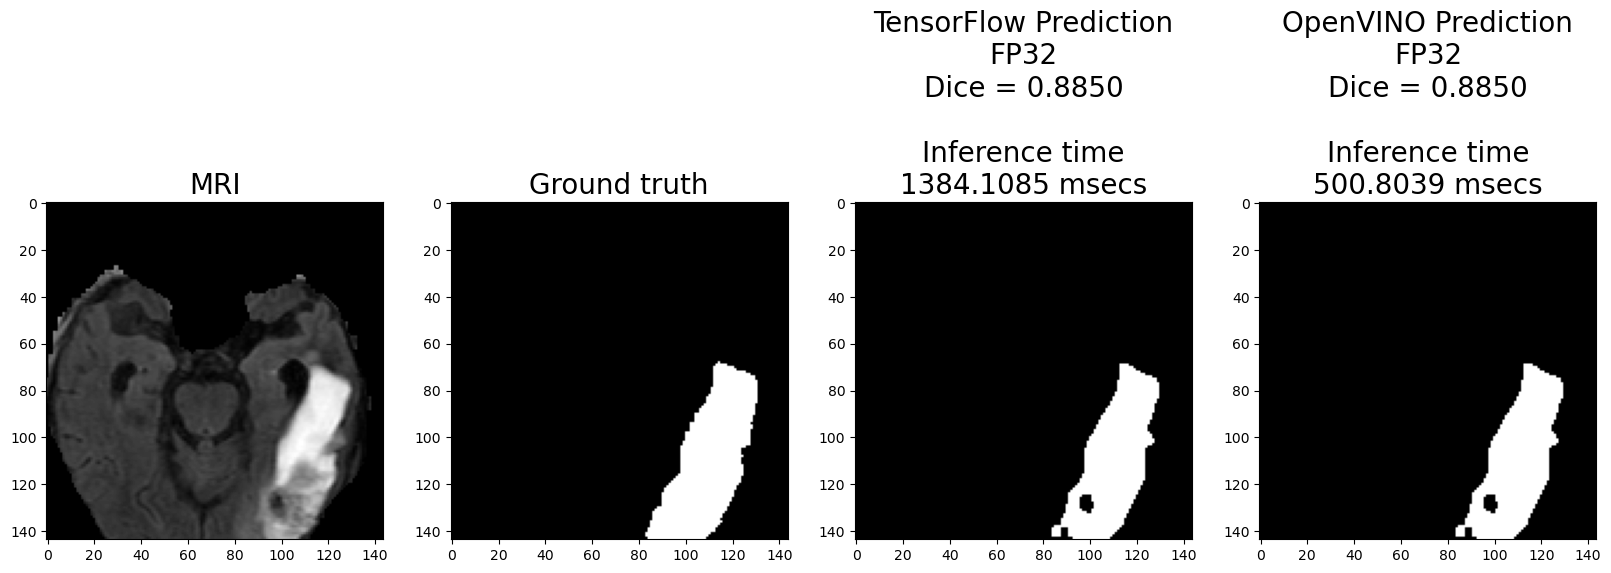

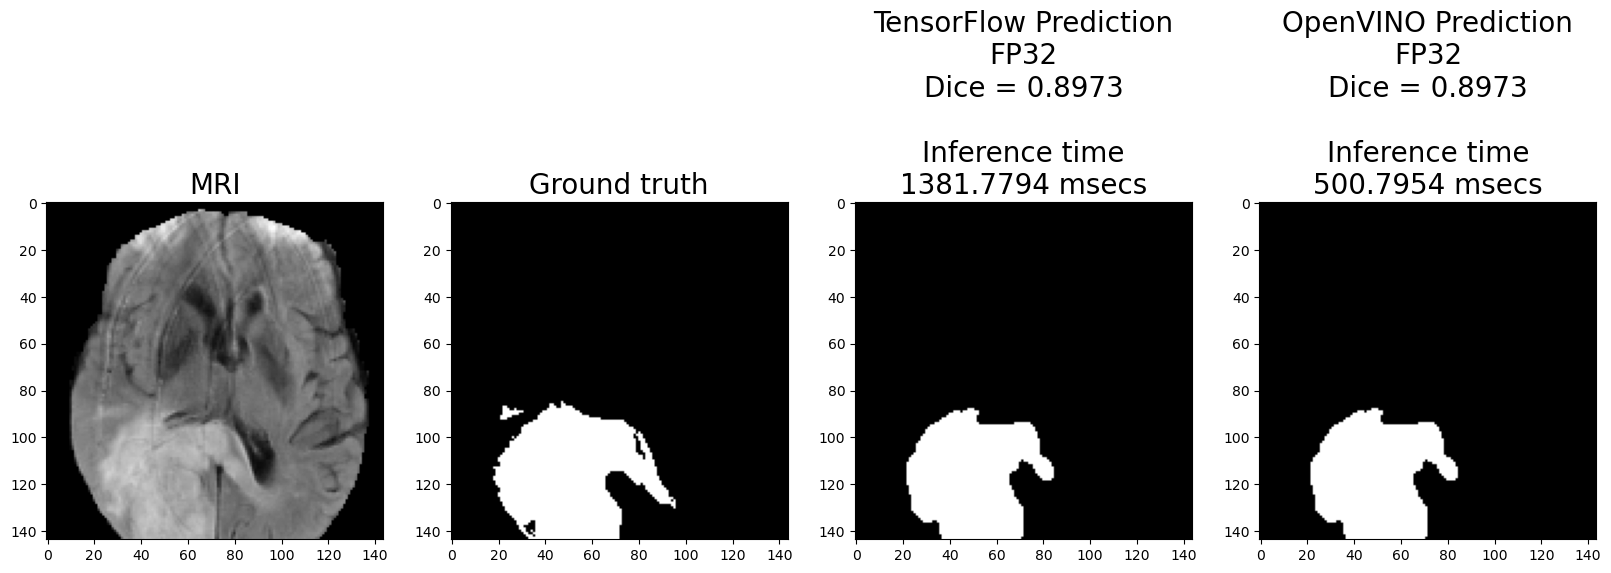

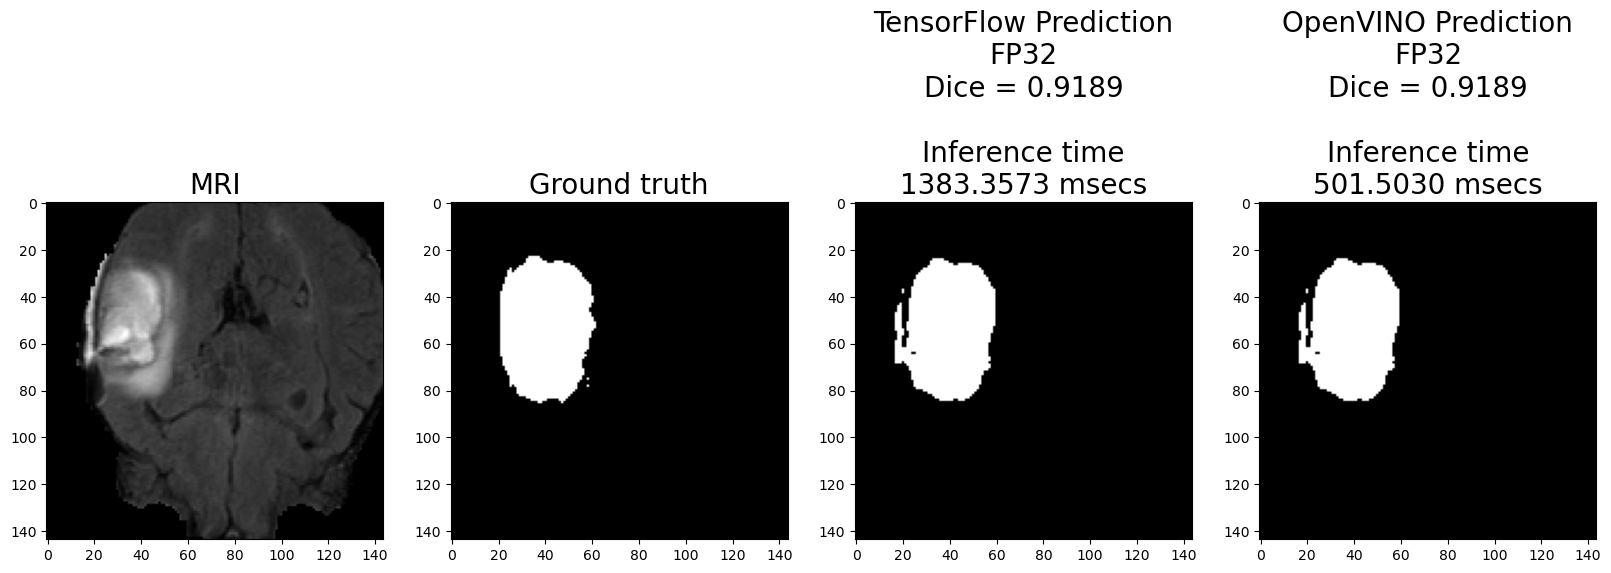

In [32]:
%matplotlib inline
ds = brats_datafiles.get_train().take(1).as_numpy_iterator()
for img, msk in ds:
    plot_predictions(img,msk)

In [48]:
from ipywidgets import AppLayout, IntSlider, Layout, VBox
import ipywidgets as widgets


def plot_interactive_predictions(img, msk, channel=0):
    img = img[:, :, :, :, channel:channel+1]
    max_img = img.shape[3]
    print(max_img)
    mid_img = int(max_img / 2)
    print(mid_img)
    
    """
    OpenVINO Model Prediction
    Note: OpenVINO assumes the input (and output) are organized as channels first (NCHWD)
    whereas TensorFlow assumes channels last (NHWDC). We'll use the NumPy transpose
    to change the order.
    """
    start_time = time.time()
    request = compiled_model.create_infer_request()
    request.infer(inputs={input_layer.any_name: img})
    prediction_ov = request.get_output_tensor(output_layer.index).data
    dice_coef_ov = calc_dice(msk,prediction_ov)
    print("OpenVINO inference time = {:.4f} msecs".format(1000.0*(time.time()-start_time)))
    
    """
    TensorFlow Model Prediction
    """
    start_time = time.time()
    prediction_tf = tf_model.predict(img)
    dice_coef_tf = calc_dice(msk,prediction_tf)
    print("TensorFlow inference time = {:.4f} msecs".format(1000.0*(time.time()-start_time)))
    
    
    plt.ioff()
    fig, ax = plt.subplots(1,1, figsize=(8,8))
    plt.ion()

   
#    ax[0].title("MRI", fontsize=20) #row=0, col=0
    im = ax.imshow(img[0,:,:,mid_img,0], cmap="gray")
#    ax[1].title("Ground Truth", fontsize=20) #row=1, col=0
#    lbl = ax[1].imshow(msk[0,:,:,mid_img,0], cmap="gray")
#    ax[2].title("OpenVINO Prediction\nDice = {:.4f}".format(dice_coef_ov), fontsize=20)
#    ovp = ax[2].imshow(prediction_ov[0,:,:,mid_img,0], cmap="gray")
#    ax[3].title("TensorFlow Prediction\nDice = {:.4f}".format(dice_coef_tf), fontsize=20) #row=1, col=1
#    tfp = ax[3].imshow(prediction_tf[0,:,:,mid_img,0], cmap="gray")
    
    
    fig.canvas.header_visible = False
    #fig.canvas.layout.min_height = '400px'
    fig.canvas.toolbar_visible = False
    plt.title('Axial View Slice n.')
    
    def update(change):
        im.set_data(img[0, :, :, change['new'],0], cmap="gray")
#        lbl.set_data(msk[0, :, :, change['new'],0], cmap="gray")
#        ovp.set_data(prediction_ov[0, :, :, change['new'],0], cmap="gray")
#        tfp.set_data(prediction_tf[0, :, :, change['new'],0], cmap="gray")
        fig.canvas.draw_idle()

        
    slider = widgets.IntSlider(orientation='horizontal', \
        description='Slice #:', value=mid_img, min=0, max=max_img)

    slider.layout.margin = '0px 0px 0px 0px'
    #slider.layout.margin = '20% 0px 20% 0px'
    slider.layout.width = '80%'
    
    slider.observe(update, names='value')
    
    
    viewer = VBox([slider, fig.canvas], layout=Layout(align_items='center'))

    #widgets.VBox([slider, fig.canvas])
    # viewer = AppLayout(
    #     center=fig.canvas,
    #     left_sidebar=slider,
    #     right_sidebar=None,
    #     pane_widths=[1, 8, 0]
    # )
    return viewer

In [49]:
%matplotlib widget
ds = ds_train.take(1).as_numpy_iterator()
#print(ds.shape)
for img, msk in ds:
    img, msk = img, msk
viewer = plot_interactive_predictions(img,msk)
display(viewer)

NameError: name 'ds_train' is not defined

In [ ]:
bz_perf = 1
ds_perf = ds_train.batch(bz_perf)
ds_perf = ds_train.prefetch(tf.data.AUTOTUNE)

In [ ]:
takes = 100
ds_perf_test = ds_perf.take(takes).as_numpy_iterator()

num_images = takes

In [ ]:
start = time.perf_counter()
counter = 0

request = compiled_model.create_infer_request()
for img, _ in ds_perf_test:
    request.infer(inputs={input_layer.any_name: img})
    #start_time = time.time()
    request.infer(inputs={input_layer.any_name: img})
    prediction_ov = request.get_output_tensor(output_layer.index).data
    dice_coef_ov = calc_dice(msk,prediction_ov)
    counter += 1
    
    #print("OpenVINO inference time = {:.4f} msecs".format(1000.0*(time.time()-start_time)))
    
    
    
    
    
end = time.perf_counter()
time_ir = end - start
print(counter)
print(
    f"IR model in Inference Engine/CPU: {time_ir/num_images:.4f} "
    f"seconds per image, FPS: {num_images/time_ir:.2f}"
)